Setting Up Environment

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
df_posts = pd.read_csv('cleaned_reddit_posts.csv')
df_comments = pd.read_csv('cleaned_reddit_comments.csv')

For network analysis, I decided focus on networks by subreddits. 
This will provide insight into which communities have the most discourse around Rodney Reed's case.

In [46]:
# subreddits with the highest number of comments 
highest_score_subreddit = df_posts.sort_values(by='num_comments', ascending=False)[['subreddit', 'num_comments', 'score']].head(10)
display(highest_score_subreddit)

,subreddit,num_comments,score
102,UnresolvedMysteries,228,211
22,politics,172,3665
50,UnresolvedMysteries,167,87
123,TrueCrimePodcasts,161,853
49,Keep_Track,133,1448
58,scotus,128,149
45,Austin,110,423
35,MorbidPodcast,104,31
33,Austin,95,287
88,Austin,83,54


In [5]:
# merge comments with posts to get subreddit info
merged_df = df_comments.merge(df_posts[['id', 'subreddit', 'num_comments', 'title', 'score']], left_on='post_id', right_on='id', how='left')

In [6]:
# load sentiment data
post_sentiment = pd.read_csv('sentiment_reddit_posts.csv')
comment_sentiment = pd.read_csv('sentiment_reddit_comments.csv')

# copy sentiment column
merged_df['post_sentiment'] = post_sentiment['sentiment']
merged_df['comment_sentiment'] = comment_sentiment['sentiment']

# copy sentiment labels
merged_df['post_sentiment_label'] = post_sentiment['sentiment_label']
merged_df['comment_sentiment_label'] = comment_sentiment['sentiment_label']

In [14]:
# build the network
G = nx.Graph()

# add nodes and edges
for idx, row in merged_df.iterrows():
    subreddit_node = row['subreddit']
    post_node = f'post_{row["post_id"]}'
    comment_node = f'comment_{row["comment_id"]}'

    # Add post node and edge to subreddit
    G.add_node(post_node, node_type='post')
    G.add_edge(post_node, subreddit_node)

    # Add comment node and edge to subreddit
    G.add_node(comment_node, node_type='comment')
    G.add_edge(comment_node, subreddit_node)

In [15]:
colors = []
node_size = []
labels = {}

for node, attrs in G.nodes(data=True):
    node_type = attrs.get('node_type', 'subreddit')
    
    if node_type == 'subreddit':
        colors.append('#92b281')  
        node_size.append(400)
        labels[node] = node
    elif node_type == 'post':
        colors.append('#1865ab')
        node_size.append(100)
    else:
        colors.append('#f46530')
        node_size.append(20)

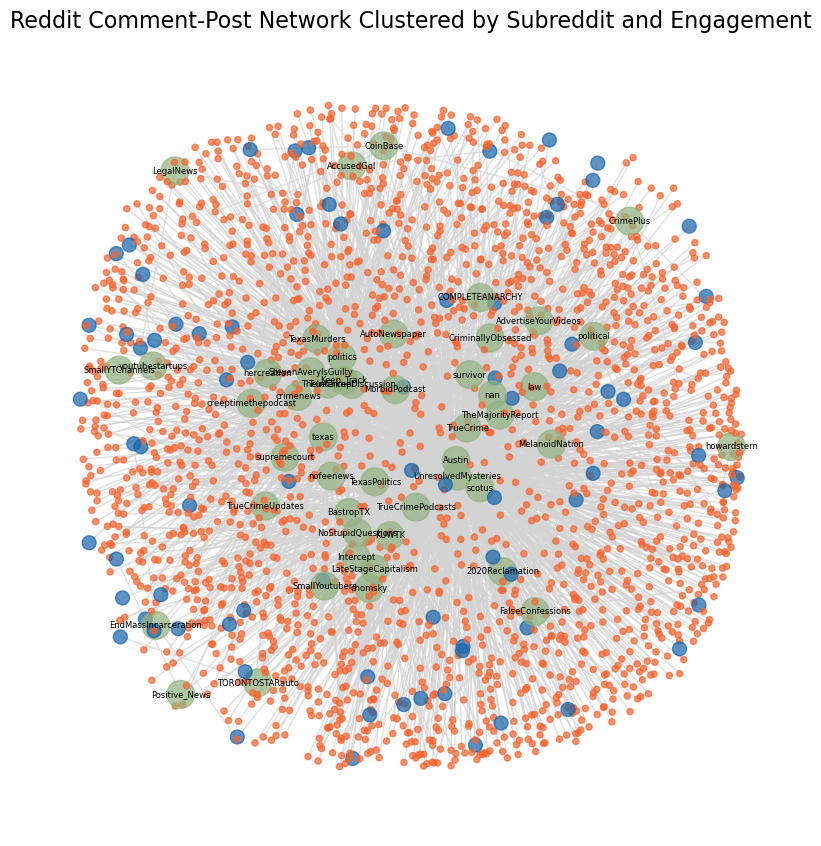

In [26]:
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.15, iterations=30, seed=42) 

nx.draw(G, pos,
        node_color=colors,
        with_labels=False,
        node_size=node_size,
        edge_color='lightgray',
        alpha=0.7)

nx.draw_networkx_labels(G, pos,
                        labels=labels,
                        font_size=6,
                        font_color='black'
                       )

plt.title('Reddit Comment-Post Network Clustered by Subreddit and Engagement', fontsize=16)
plt.show()

Calculate centrality measures

In [17]:
# Betweenness Centrality
betweenness = nx.betweenness_centrality(G)

betweenness_df = pd.DataFrame(list(betweenness.items()), columns=['node', 'Betweenness'])
betweenness_df = betweenness_df.sort_values(by='Betweenness', ascending=False)
display(betweenness_df.head(10))

,node,Betweenness
30,Austin,0.044732
920,UnresolvedMysteries,0.025250
189,politics,0.006910
1590,TrueCrimePodcasts,0.005246
521,scotus,0.004322
791,Keep_Track,0.003230
569,MorbidPodcast,0.002790
83,TrueCrimeDiscussion,0.002559
672,texas,0.001385
1479,TrueCrime,0.001132


In [18]:
# Degree Centrality
degree = nx.degree_centrality(G)

degree_df = pd.DataFrame(list(degree.items()), columns=['Node', 'Degree'])
degree_df = degree_df.sort_values(by='Degree', ascending=False)
display(degree_df.head(10))

,Node,Degree
30,Austin,0.211676
920,UnresolvedMysteries,0.159091
189,politics,0.083333
1590,TrueCrimePodcasts,0.072638
521,scotus,0.065954
791,Keep_Track,0.057041
569,MorbidPodcast,0.053030
83,TrueCrimeDiscussion,0.050802
672,texas,0.037433
1479,TrueCrime,0.033868


In [19]:
# Closeness Centrality
closeness = nx.closeness_centrality(G)

closeness_df = pd.DataFrame(list(closeness.items()), columns=['Node', 'Closeness'])
closeness_df = closeness_df.sort_values(by='Closeness', ascending=False)
display(closeness_df.head(10))

,Node,Closeness
30,Austin,0.211676
920,UnresolvedMysteries,0.159091
492,comment_jh2h7nc,0.105949
491,comment_jgy60y5,0.105949
473,comment_jh1xdgb,0.105949
472,comment_jgxpyro,0.105949
488,comment_jgyd39b,0.105949
503,comment_jh33ow8,0.105949
502,comment_jgya76o,0.105949
485,comment_jgy1zy0,0.105949


In [20]:
# Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)  # Increase iterations if needed

eigenvector_df = pd.DataFrame(list(eigenvector.items()), columns=['Node', 'Eigenvector'])
eigenvector_df = eigenvector_df.sort_values(by='Eigenvector', ascending=False)
display(eigenvector_df.head(10))

,Node,Eigenvector
30,Austin,0.707061
509,comment_jhgeypn,0.032446
492,comment_jh2h7nc,0.032446
486,comment_jh1xj6j,0.032446
485,comment_jgy1zy0,0.032446
468,comment_jgyj8lx,0.032446
488,comment_jgyd39b,0.032446
503,comment_jh33ow8,0.032446
502,comment_jgya76o,0.032446
501,comment_jgy9isa,0.032446


To gain better insight into the top 2 subreddit that has the highest centrality, I will extract information about them.

"Austin" Subreddit

In [7]:
# subreddit 'Austin' overview
austin_posts = merged_df[merged_df['subreddit'] == 'Austin']['post_id'].value_counts()
austin_comments = merged_df[merged_df['subreddit'] == 'Austin']['comment_id'].value_counts()
print(f'There are {len(austin_posts)} post and {len(austin_comments)} comments within this subreddit.')

There are 8 post and 467 comments within this subreddit.


In [22]:
# 'Austin' subreddit statistics on score, number of comments, and sentiment
austin_subreddit = merged_df[merged_df['subreddit'] == 'Austin']
print(f'Austin Subreddit Statistics:')
# 'score_x' is comment score & score_y is post score
display(austin_subreddit.describe()[['score_y', 'score_x', 'num_comments', 'post_sentiment', 'comment_sentiment']])

Austin Subreddit Statistics:


,score_y,score_x,num_comments,post_sentiment,comment_sentiment
count,467.000000,467.000000,467.000000,47.000000,467.000000
mean,178.760171,3.554604,80.077088,-0.100368,-0.429845
std,164.880378,8.407201,25.862679,0.485932,0.550000
min,5.000000,-31.000000,12.000000,-0.999700,-0.999200
25%,38.000000,1.000000,53.000000,-0.538050,-0.921900
50%,63.000000,2.000000,83.000000,-0.077200,-0.599400
75%,287.000000,4.000000,95.000000,0.250000,0.000000
max,423.000000,81.000000,110.000000,0.993200,0.985300


In [139]:
# number of each post sentiment label within subreddit
austin_post_sentiment = austin_subreddit['post_sentiment_label'].value_counts()
display(austin_post_sentiment)

post_sentiment_label
Negative    29
Positive    17
Neutral      1
Name: count, dtype: int64

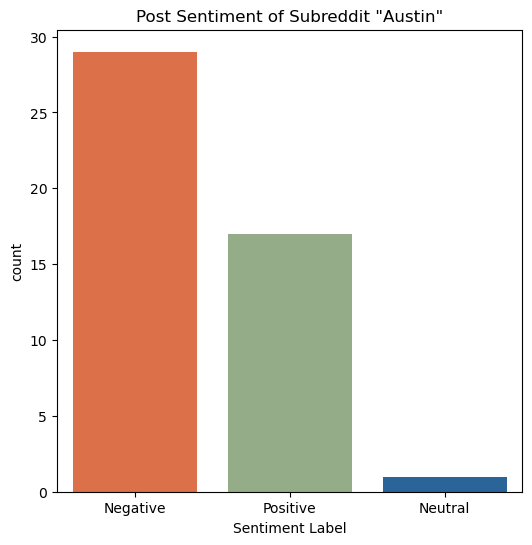

In [144]:
# Post Sentiment of Subreddit 'Austin'
custom_colors = {
    'Positive': "#92b281",   
    'Negative': "#f46530",  
    'Neutral': "#1865ab"  
}

plt.figure(figsize=(6, 6))
sns.countplot(x='post_sentiment_label', data=austin_subreddit, palette=custom_colors)
plt.title('Post Sentiment of Subreddit "Austin"')
plt.xlabel('Sentiment Label')
plt.show()

In [140]:
# number of comment sentiment labels within subreddit
austin_comment_sentiment = austin_subreddit['comment_sentiment_label'].value_counts()
display(austin_comment_sentiment)

comment_sentiment_label
Negative    334
Positive     89
Neutral      44
Name: count, dtype: int64

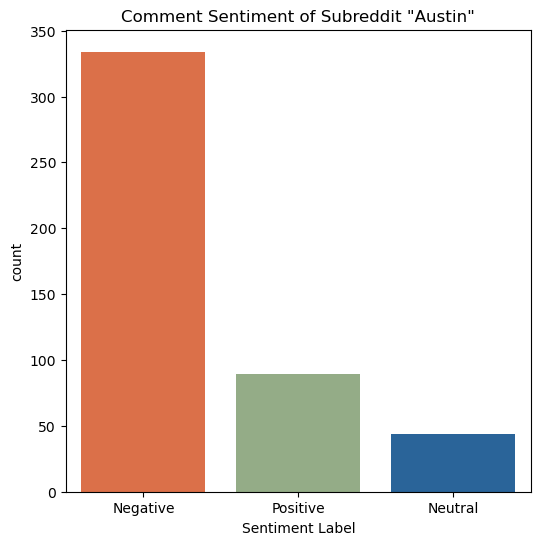

In [143]:
# Comment Sentiment of Subreddit 'Austin'
custom_colors = {
    'Positive': "#92b281",   
    'Negative': "#f46530",  
    'Neutral': "#1865ab"  
}

plt.figure(figsize=(6, 6))
sns.countplot(x='comment_sentiment_label', data=austin_subreddit, palette=custom_colors)
plt.title('Comment Sentiment of Subreddit "Austin"')
plt.xlabel('Sentiment Label')
plt.show()

In [23]:
# comments sorted by the highest score 
highest_score_austin = austin_subreddit.sort_values(by='score_x', ascending=False)[['post_id', 'comment_id', 'score_x', 'comment_sentiment', 'depth', 'date']].head(15)
display(highest_score_austin)

,post_id,comment_id,score_x,comment_sentiment,depth,date
628,y0qp7g,irtmg7p,81,-0.8600,0,2022-10-10
645,y0qp7g,irtsz3k,80,0.8157,1,2022-10-11
388,12s363v,jgy20r1,57,-0.9739,0,2023-04-19
1171,qkh1yo,hiwq6rn,48,-0.9992,0,2021-11-01
389,12s363v,jgwlj37,47,-0.0772,0,2023-04-19
1170,qkh1yo,hiwapoe,38,-0.3182,0,2021-11-01
1184,qkh1yo,hiwrsem,28,-0.7269,1,2021-11-01
1182,qkh1yo,hiwvqsn,24,-0.5859,1,2021-11-01
393,12s363v,jgy8uff,23,-0.9724,1,2023-04-20
1183,qkh1yo,hixjwcx,21,-0.4101,1,2021-11-01


In [121]:
# post 'y0qp7g' statistics
austin_top_post = merged_df[merged_df['id'] == 'y0qp7g']
print(f'Post "y0qp7g" - \nTotal Number of Comments: {len(austin_top_post)} comments. \nPost Score: {austin_top_post["score_y"].max()} \nAverage Comment Score: {austin_top_post["score_x"].mean():.2f} \nAverage Comment Sentiment: {austin_top_post["comment_sentiment"].mean():.2f} \n')
display(austin_top_post.describe()[['score_x', 'depth', 'comment_sentiment']])

Post "y0qp7g" - 
Total Number of Comments: 108 comments. 
Post Score: 423.0 
Average Comment Score: 4.08 
Average Comment Sentiment: -0.24 



,score_x,depth,comment_sentiment
count,108.000000,108.000000,108.000000
mean,4.083333,2.833333,-0.241830
std,11.865386,2.202378,0.610177
min,-31.000000,0.000000,-0.996400
25%,1.000000,1.000000,-0.794025
50%,1.000000,2.500000,-0.434550
75%,4.000000,4.000000,0.239325
max,81.000000,9.000000,0.963200


In [101]:
# view post 'y0qp7g'
tp_austin = df_posts[df_posts['id'] == 'y0qp7g']
pd.set_option('display.max_colwidth', None)
display(tp_austin[['id', 'title', 'date', 'score', 'num_comments', 'domain']])

,id,title,date,score,num_comments,domain
45,y0qp7g,Texas Claims It’s “Too Late” for DNA Testing That Could Get Rodney Reed Off Death Row | Now Reed is taking his fight to the Supreme Court.,2022-10-10,423,110,theintercept.com


In [112]:
# view comments on post 'y0qp7g' sorted by score
pd.set_option('display.max_colwidth', None)
display(austin_top_post.sort_values(by='score_x', ascending=False)[['comment_id', 'body', 'date', 'score_x']].head(5))

,comment_id,body,date,score_x
628,irtmg7p,"DNA testing shouldn’t take very long. Not sure how it can be too late to present new evidence before the state murders you.\n\nEdit: Not familiar with the case, so I can’t speak to whether this is a stalling tactic or if the defendant is likely to be found innocent. In general people convicted and sent to death row have already been through multiple trials I know.",2022-10-10,81
645,irtsz3k,"> DNA testing shouldn’t take very long.\n\nYou've misunderstood the problem here.\n\nThe problem isn't that there is not time left to do DNA testing; the problem is that he's already been convicted, so Texas is done with such things and doesn't want to revisit the case.\n\nThere are appeals, but the appeals courts look for errors made in the legal process, and ""an innocent man was convicted"" is not the sort of error that the appeals courts really care about; instead, they're after things like evidence that was improperly collected, jurors received improper instructions, stuff like that -- errors made in the legal process. And in general, ordinary people generally fail in their appeals, but elites have much better luck (in the few cases where they're actually convicted.)\n\nSeriously, Texas's justice system cares way more about the idea that its processes were followed properly than if it has sentenced an innocent person for a crime that they didn't commit, and they have to be dragged, kicking and screaming, to even look at new evidence (or old evidence that was misunderstood or missed) in a case, even if that evidence makes it pretty clear that they convicted an innocent person.\n\n(That said, I also have no special knowledge about *this* case, so I don't know if this evidence really is critical or what, but as far as Texas is concerned, the time for presenting evidence ended when he was found guilty, and it takes a *lot* to convince them otherwise.)",2022-10-11,80
693,irtx27t,"If there is DNA then it should always be tested, always. That should be a minimum requirement before the state puts someone to death, period.\n\nI don’t care if they are a scumbag, if they didn’t they didn’t commit crime they are being put to death for then the real killer is literally getting away with murder.",2022-10-11,21
632,iru8bwf,"That position piece article failed to mention that Rodney Reed raped other women and a 12-year old girl. \n\nI’m generally a liberal but Rodney Reed was guilty as hell. I went on a long internet dive on this a few years ago, read court transcripts, everything.",2022-10-11,19
630,irty2um,*sigh* This is infuriating...seriously infuriating. Surprising? No. Not at all.,2022-10-11,19


"UnresolvedMysteries" Subreddit

In [32]:
# subreddit 'UnsolvedMysteries' overview
um_posts = merged_df[merged_df['subreddit'] == 'UnresolvedMysteries']['post_id'].nunique()
um_comments = merged_df[merged_df['subreddit'] == 'UnresolvedMysteries']['comment_id'].nunique()
print(f'There are {um_posts} post and {um_comments} comments within this subreddit.')

There are 2 post and 355 comments within this subreddit.


In [24]:
# 'UnresolvedMysteries' subreddit statistics on score, number of comments, and sentiment
um_subreddit = merged_df[merged_df['subreddit'] == 'UnresolvedMysteries']
print(f'Unresolved Mysteries Subreddit Statistics:')
# 'score_x' is comment score & score_y is post score
display(um_subreddit.describe()[['score_y', 'score_x','num_comments', 'comment_sentiment']])

Unresolved Mysteries Subreddit Statistics:


,score_y,score_x,num_comments,comment_sentiment
count,355.000000,355.000000,355.000000,355.000000
mean,162.098592,11.540845,203.943662,-0.306733
std,60.686086,26.577047,29.853639,0.599673
min,87.000000,-18.000000,167.000000,-0.999800
25%,87.000000,1.000000,167.000000,-0.858600
50%,211.000000,3.000000,228.000000,-0.488300
75%,211.000000,11.000000,228.000000,0.153100
max,211.000000,242.000000,228.000000,0.989700


In [198]:
# number of comment sentiment labels within subreddit
um_comment_sentiment = um_subreddit['comment_sentiment_label'].value_counts()
display(um_comment_sentiment)

comment_sentiment_label
Negative    224
Positive     94
Neutral      37
Name: count, dtype: int64

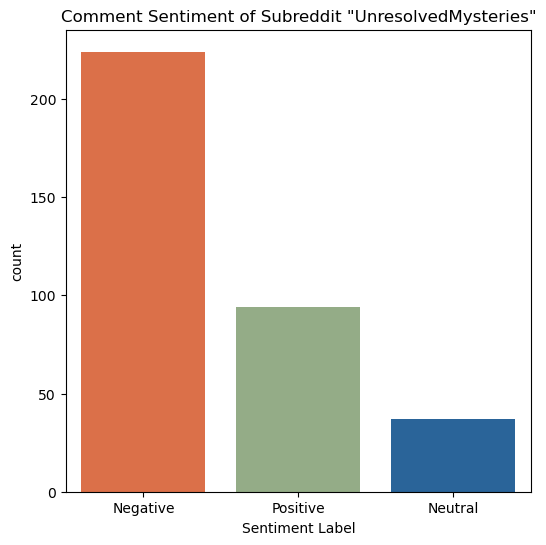

In [199]:
# Comment Sentiment of Subreddit 'UnresolvedMysteries'
custom_colors = {
    'Positive': "#92b281",   
    'Negative': "#f46530",  
    'Neutral': "#1865ab"  
}

plt.figure(figsize=(6, 6))
sns.countplot(x='comment_sentiment_label', data=um_subreddit, palette=custom_colors)
plt.title('Comment Sentiment of Subreddit "UnresolvedMysteries"')
plt.xlabel('Sentiment Label')
plt.show()

In [25]:
# comments sorted by the highest score
highest_score_um = um_subreddit.sort_values(by='score_y', ascending=False)[['comment_id', 'score_x', 'comment_sentiment', 'depth', 'date']].head(15)
display(highest_score_um)

,comment_id,score_x,comment_sentiment,depth,date
1745,gfow4bp,0,0.2960,1,2020-12-13
1744,gfh3zbq,0,0.5994,1,2020-12-12
1705,idoyjjw,1,-0.8720,4,2022-06-25
1706,gff7rmw,1,-0.8785,4,2020-12-11
1707,gfai3c9,1,0.7003,4,2020-12-10
1708,gfe6bue,2,0.0000,4,2020-12-11
1709,gfbmxxm,1,-0.9604,4,2020-12-10
1710,gfefl2j,4,0.6369,4,2020-12-11
1711,gfe6r95,4,0.3724,4,2020-12-11
1712,gfdc94m,1,0.8770,4,2020-12-11


In [120]:
# post 'k9zbbe' statistics
um_top_post = merged_df[merged_df['id'] == 'k9zbbe']
print(f'Commenter "k9zbbe" - \nTotal Number of Comments: {len(um_top_post)} comments. \nPost Score: {um_top_post["score_y"].max()} \nAverage Comment Score: {um_top_post["score_x"].mean():.2f} \nAverage Comment Sentiment: {um_top_post["comment_sentiment"].mean():.2f} \n')
display(um_top_post.describe()[['score_x', 'depth', 'comment_sentiment']])

Commenter "k9zbbe" - 
Total Number of Comments: 215 comments. 
Post Score: 211.0 
Average Comment Score: 15.95 
Average Comment Sentiment: -0.35 



,score_x,depth,comment_sentiment
count,215.000000,215.000000,215.000000
mean,15.948837,2.158140,-0.348665
std,32.849731,1.909914,0.603130
min,-18.000000,0.000000,-0.999800
25%,1.000000,1.000000,-0.888750
50%,5.000000,2.000000,-0.585300
75%,16.500000,3.000000,0.183250
max,242.000000,9.000000,0.972200


In [39]:
# view post 'k9zbbe'
tp_um = df_posts[df_posts['id'] == 'k9zbbe']
pd.set_option('display.max_colwidth', None)
display(tp_um[['id', 'title', 'date', 'score', 'num_comments']])

,id,title,date,score,num_comments
102,k9zbbe,Kim Kardashian and other celebs believe Rodney Reed was wrongfully convicted for the murder of Stacey Stites. What do you think?,2020-12-09,211,228


In [43]:
# view comments of post 'k9zbbe'
pd.set_option('display.max_colwidth', None)
display(um_commenter.sort_values(by='score', ascending=False)[['comment_id', 'body', 'date', 'score', 'num_comments', 'comment_sentiment']].head(5))

comment_id  \
1533    gf7cjxy   
1536    gf7hkc7   
1532    gfaogsl   
1531    gfjjgq4   
1584    gf7fo6q   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  